In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import re
import os
import os.path as osp
import sys
import time
import glob
import cv2
from pathlib import Path
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split, Subset

import torchvision
from torchvision import datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

from dataset import CVATDataset, COCODataset
from dataset import variable_shape_collate_fn
import transforms
from transforms import BoundingBoxFormatConvert,ToX1y1x2y2Abs, ToCxcywhRel, ToIaa, iaa_hsv_aug, iaa_random_crop, iaa_letterbox, \
                       IaaAugmentations, ToNp, IaaLetterbox, ToTensor, Compose
from boundingbox import bbox_x1y1x2y2_to_xywh, bbox_x1y1x2y2_to_cxcywh, bbox_cxcywh_to_x1y1x2y2, bbox_cxcywh_to_xywh, \
                        bbox_xywh_to_cxcywh, bbox_xywh_to_x1y1x2y2, CoordinateType, FormatType, BoundingBoxConverter
from imgaug import augmenters as iaa
from utils import postprocessing, letterbox_transforms, letterbox_label_reverse
from draw import show_img, draw_rect, draw_text, \
                 cv2_drawTextWithBkgd, get_color_pallete
from darknet import YoloNet
from train import *



# Paths

In [2]:
weight_path = './yolov3.weights'
backbone_weight_path = './darknet53.conv.74'
classes_path = './x_wing.names'
classes_names = ['x_wing', 'tie']
cvat_img_dir = './custom_data/x_wing'
label_xml_path = './custom_data/7_x_wing.xml'
output_dir = './output'

In [3]:
cv2.setNumThreads(0)

# Training

## Set up dataloader

In [4]:
def getTransforms(dim, bbs_idx=np.arange(0,4),
                  coord_type=CoordinateType.Relative, format_type=FormatType.cxcywh, aug=True):
    if aug:
        transform = Compose([ToX1y1x2y2Abs(coord_type, format_type, bbs_idx),
                             ToIaa(bbs_idx),
                             IaaAugmentations([iaa_hsv_aug(0.1, 1.5, 1.5),
                                               iaa_random_crop(0.3),
                                               iaa.Fliplr(0.5)
                                              ]),
                             IaaLetterbox(dim),
                             ToNp(bbs_idx),
                             ToCxcywhRel(CoordinateType.Absolute, FormatType.x1y1x2y2, bbs_idx),
                             ToTensor()])
    else:
        transform = Compose([ToX1y1x2y2Abs(coord_type, format_type, bbs_idx),
                             ToIaa(bbs_idx),
                             IaaLetterbox(dim),
                             ToNp(bbs_idx),
                             ToCxcywhRel(CoordinateType.Absolute, FormatType.x1y1x2y2, bbs_idx),
                             ToTensor()])
    return transform

In [5]:
def getData(sz, bs, shuffle=True, isAug=True):
    dim = (sz, sz)
    
    transform = getTransforms(dim, bbs_idx=np.arange(1,5),
                              coord_type=CoordinateType.Absolute, format_type=FormatType.cxcywh, aug=isAug)
    
    train_ds = CVATDataset(cvat_img_dir, label_xml_path, dim=dim, transform=transform)
    
#     sub_idx = np.arange(1,100)
#     train_ds = Subset(train_ds, sub_idx)   
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=shuffle, collate_fn=variable_shape_collate_fn, num_workers=4)
    
    dataloader = dict()
    dataloader['train'] = train_dl
    dataloader['valid'] = None
    
    return dataloader

## Initial training

In [6]:
ratio = 10 * 10
lr = 0.01 / ratio
momentum=0.9
wd=0.0005
sz = 416
bs = 16
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1
darknet53_lr = 0.001 / ratio
yolo_lr = 0.01

In [7]:
epoch = 100
model_id = 'x_wing_5'
weight_dir_path = './weights'

remove_checkpoints(model_id, weight_dir_path)

net = YoloNet((sz, sz), numClass=2).cuda()
net.feature.loadWeight(backbone_weight_path)

train(getData(sz, bs, False, False), net, epoch,
      lr, darknet53_lr, wd, momentum,
      0, 0, #lr_scheduler_decay_step, lr_scheduler_decay_gamma,
      model_id=model_id, start_epoch=0, weight_dir=weight_dir_path, checkpoint_interval=5,
      resume_checkpoint=None, use_gpu=True)

./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0044.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0089.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0084.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0059.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0099.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0049.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0029.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0004.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0094.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0024.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0054.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0039.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0069.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0064.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0074.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0009.pth.tar
./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0014.pth.t

   49  0.0451150 0.0396344 0.0060154 0.0057141 0.0599229 0.0319214  0.1883233 0.9795715                                                 
   50  0.0317057 0.0446968 0.0044585 0.0049244 0.0457276 0.0287273  0.1602403 0.9835575                                                 
   51  0.0250552 0.0290879 0.0052805 0.0071498 0.0508897 0.0272658  0.1447290 0.9815645                                                 
   52  0.0254283 0.0379395 0.0078021 0.0104369 0.1534626 0.0257123  0.2607817 0.9561535                                                 
   53  0.0165817 0.0321616 0.0122786 0.0169627 0.1037558 0.0232360  0.2049764 0.9556552                                                 
   54  0.0115335 0.0394368 0.0229113 0.0236514 0.1066403 0.0259317  0.2301050 0.9556552                                                 
   55  0.0126867 0.0227689 0.0047345 0.0054469 0.0651989 0.0236465  0.1344823 0.9810663                                                 
   56  0.0124202 0.0192118 0.0018354 0.00

## Resume training (make sure 'model_id' matches)

In [6]:
def resume_training(max_epoch, model_id, weight_dir):
    pt_weight_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir)
    if pt_weight_path is not None:
        print('Loading %s' % pt_weight_path)
        
        checkpoint = load_checkpoint(pt_weight_path)
        net = YoloNet((sz, sz), numClass=2).cuda()
                         
        train(getData(sz, bs), net, max_epoch,
              lr, darknet53_lr,
              wd, momentum,
              0, 0, #lr_scheduler_decay_step, lr_scheduler_decay_gamma,
              model_id=model_id, start_epoch=latest_epoch+1, weight_dir=weight_dir, checkpoint_interval=20,
              resume_checkpoint=checkpoint,
              use_gpu=True)
    else:
        print("No checkpoint for %d found" % model_id)

In [7]:
ratio = 10 * 10
lr = 0.01 / ratio
momentum=0.9
wd=0.0005
sz = 416
bs = 16
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1
darknet53_lr = 0.001 / ratio
yolo_lr = 0.01

In [ ]:
#epoch 12 changed loss function
epoch = 100
model_id = 'x_wing_5'
weight_dir = './weights'
resume_training(epoch, model_id, weight_dir)

## Test model on images

In [8]:
from utils import nms, reduce_row_by_column, bbox_iou, iou_vectorized, torch_unique, unqiue_with_order

def postprocessing(detections, num_classes, obj_conf_thr=0.5, nms_thr=0.4):
    #print((detections[..., 4] > 0.5).nonzero())
    #Zero bounding box with objectioness confidence score less than threshold 
    obj_conf_filter = (detections[:,:,4] > obj_conf_thr).float().unsqueeze(2)
    detections = detections * obj_conf_filter
           
    #Transform bounding box coordinates to two corners
    box = detections.new(detections[:,:,:4].shape)
    box[:,:,0] = detections[:,:,0] - detections[:,:,2]/2
    box[:,:,1] = detections[:,:,1] - detections[:,:,3]/2
    box[:,:,2] = box[:,:,0] + detections[:,:,2]
    box[:,:,3] = box[:,:,1] + detections[:,:,3]
    detections[:,:,:4] = box
    
    num_batches = detections.shape[0]
    #results = torch.Tensor().to(device)
    results = list()
        
    for b in range(num_batches):
        batch_results = torch.Tensor().cuda()
        img_det = detections[b]
        
        
        max_class_score, max_class_idx= torch.max(img_det[:,5:5 + num_classes], 1)
        img_det = torch.cat((img_det[:,:5],
                             max_class_score.float().unsqueeze(1),
                             max_class_idx.float().unsqueeze(1)
                            ), 1)
        #img det - [b1_x, b1_y, b2_x, b2_y, obj_conf, class_score, class]
        
        #Remove zeroed rows
        nonzero_idx =  img_det[:,4].nonzero()
        img_det = img_det[nonzero_idx,:].view(-1,7)
               
        if img_det.shape[0] == 0:
            results.append(batch_results)
        else:
            #Get the classes
            img_classes = torch_unique(img_det[:,-1])
            for c in img_classes:
                # Select rows with "c" class and sort by the class score
                class_img_det = img_det[(img_det[:,-1] == c).nonzero().squeeze()]
                # If there is only one detection, it will return a 1D tensor. Therefore, we perform a view to keep it in 2D
                class_img_det = class_img_det.view(-1, 7)
                #Sort by objectness score
                _, sort_idx = class_img_det[:,4].sort(descending=True)
                class_img_det = class_img_det[sort_idx]

                iou = iou_vectorized(class_img_det)
                #Alert: There's another loop operation in nms function
                class_img_det = nms(class_img_det, iou, nms_thr)
                batch_results = torch.cat((batch_results, class_img_det), 0)

            results.append(batch_results)
    
    return results

In [49]:
def test_model(model_id, classes_names):
    sz = 416
    bs = 16
    dim = (sz, sz)
    
    weight_dir = './weights'
    output_dir = './output/' + model_id
    output_img_dir = output_dir + '/img'
    output_label_dir = output_dir + '/label'
    
    pt_weight_path, _ = get_latest_checkpoint(model_id, weight_dir)
    print('Loading %s' % pt_weight_path)
    checkpoint = load_checkpoint(pt_weight_path)
    #checkpoint = load_checkpoint('./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0054.pth.tar')
    
    dataloader = getData(sz, bs, shuffle=False, isAug=False)['train']
    net = YoloNet(dim, numClass=2).cuda().eval()
    net.load_state_dict(checkpoint['net'])
    
    write_detections(net, dataloader, output_img_dir, output_label_dir, classes_names)
    return output_img_dir, output_label_dir


def write_detections(net, dataloader, output_img_dir, output_label_dir, classes_names, font_scale=2.0, font=cv2.LINE_AA, line_width=4):
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)
    bbox_colors = get_color_pallete(20)
    
    with torch.no_grad(): 
        for batch, sample in enumerate(dataloader):
            inp = sample['img']
            det1, det2, det3 = net(inp.cuda(), None)
            predictions = postprocessing(torch.cat((det1,det2,det3), 1), 80, obj_conf_thr=0.5, nms_thr=0.4)
            
            for i, (img, lb_reverter, img_path, predictions) in enumerate(zip(sample['org_img'], sample['lb_reverter'], sample['img_path'], predictions)):
                img = np.ascontiguousarray(img.numpy().transpose(1, 2, 0))
                img_w, img_h = img.shape[1], img.shape[0]
                labels = predictions.cpu()
                
                # Letterbox reverse, box format of predictions are expected to be in x1y1x2y2 and absolute
                if labels is not None and len(labels) != 0:
                    org_img, padded_dim, x_pad, y_pad = tuple(lb_reverter[0:2]), tuple(lb_reverter[2:4]), lb_reverter[4], lb_reverter[5]
                    labels = transforms.letterbox_reverter(labels, org_img, padded_dim, x_pad, y_pad, np.array([0,1,2,3]))
                
                for l in labels:
                    box_coord = l[0:4]
                    cls = l[6]

                    cls_text = classes_names[cls.int().item()]
                    cls_color = bbox_colors[cls.int().item() % 20].numpy().astype(np.float64)

                    pt1 = tuple(box_coord[0:2].int().numpy())
                    pt2 = tuple(box_coord[2:4].int().numpy())
                    
                    img = cv2.rectangle(img, pt1, pt2, cls_color, 4)
                    img = cv2_drawTextWithBkgd(img, cls_text, pt1, cls_color, img_w, img_h, font_scale=font_scale, font=font)
                
                img = (img * 255).astype(np.int32)
                img_name = Path(img_path).stem
                # Uncomment to show immediate batch
                #show_img(img, figsize=(16,8))
                #print(img_path)
                cv2.imwrite(osp.join(output_img_dir, img_name + '.jpg'), img)
                save_labels(osp.join(output_label_dir, img_name + '.txt'), labels)

            
def read_detections(img_dets_dir, idx=0, bs=4):
    img_dets_list = sorted([osp.join(img_dets_dir, f) for f in os.listdir(img_dets_dir)])
    for i in range(idx, idx + bs):
        if i >= len(img_dets_list) - 1:
            break
        img_path = img_dets_list[i]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        show_img(img, figsize=(16,8))
        print(img_path)

def save_labels(save_path, labels, inp_fmt="x1 y1 x2 y2 conf cls clsId", out_fmt="clsId conf x1 y1 x2 y2"):
    if len(labels) == 0:
        return
    
    inp_dict = {v:i for i,v in enumerate(inp_fmt.split(' '))}
    out_list = out_fmt.split(' ')
    out_idx = [inp_dict[i] for i in out_list]
    out = labels[..., out_idx]
    fmt = []
    for o in out_list:
        if o == 'clsId':
            fmt.append('%d')
        else:
            fmt.append('%.6f')
    fmt = ' '.join(fmt)
    np.savetxt(save_path, out, fmt)

In [50]:
output_img_dir, output_label_dir = test_model('x_wing_5', classes_names)

Loading ./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0099.pth.tar


./output/x_wing_5/img/x_wing_0379.jpg
./output/x_wing_5/img/x_wing_0380.jpg
./output/x_wing_5/img/x_wing_0381.jpg
./output/x_wing_5/img/x_wing_0382.jpg
./output/x_wing_5/img/x_wing_0383.jpg


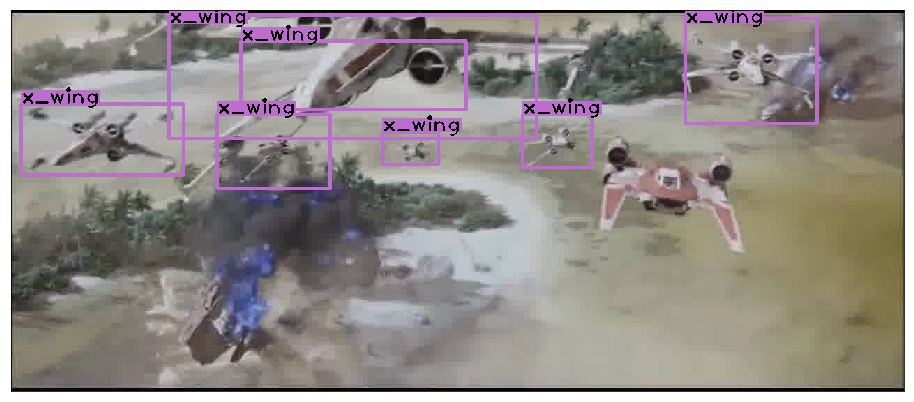

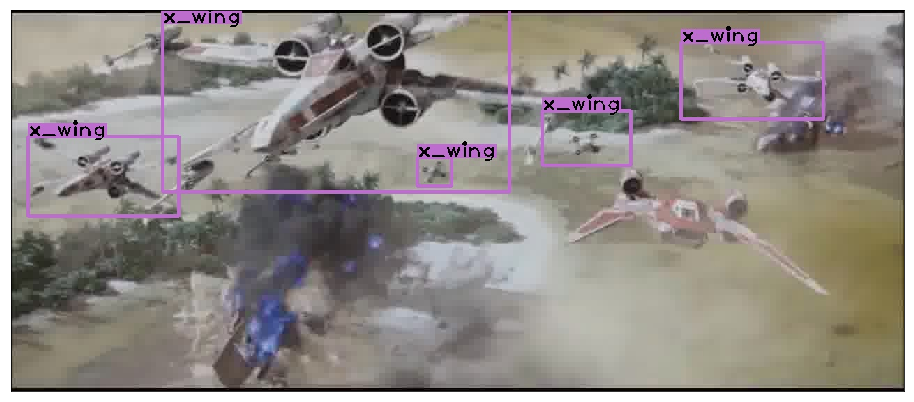

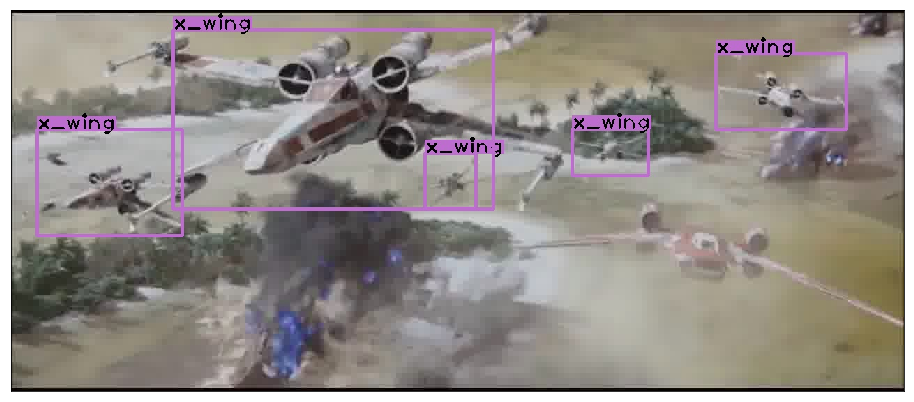

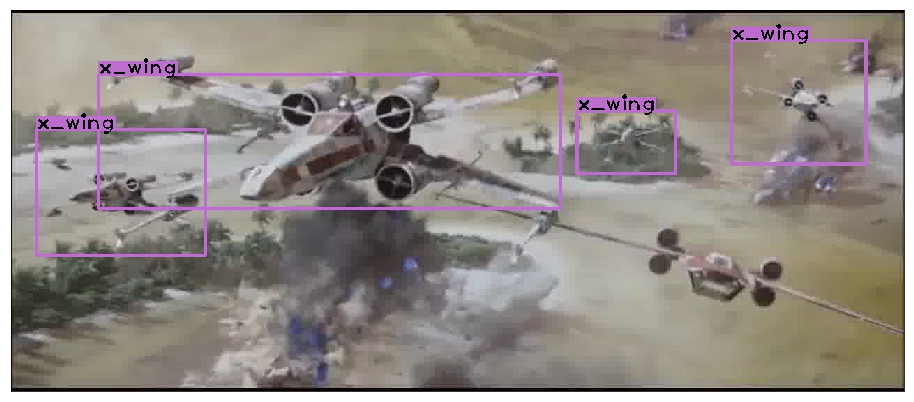

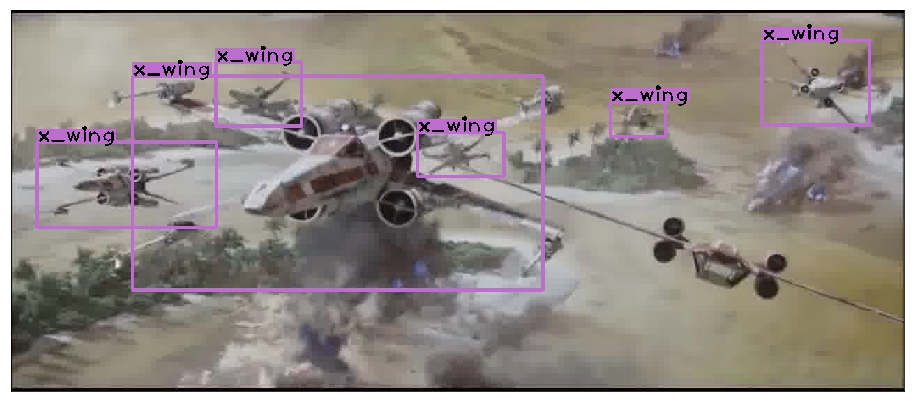

In [52]:
read_detections(output_img_dir, 200, 5)